In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 40
dt = 2
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [5]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(156, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente
modelo = MyModel(156, dt, x_max, x_min, y_min, y_max, plenum_sys)

# Criar o otimizador novamente
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.0001)

# Carregar o checkpoint salvo
checkpoint = torch.load('modelo_checkpoint.pth')

# Restaurar os estados
modelo.load_state_dict(checkpoint['modelo_state_dict'])
otimizador.load_state_dict(checkpoint['otimizador_state_dict'])

# Colocar o modelo em modo de treinamento
modelo.train()

/tmp/ipykernel_19901/1908234814.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('modelo_checkpoint.pth')


MyModel(
  (rnn_layer): LSTM(7, 156, batch_first=True)
  (dense_layers): Sequential(
    (0): Linear(in_features=156, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=14, bias=True)
  )
)

In [7]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=4,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

/home/matheus/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/4], Train Loss: 572.259937, Val Loss: 73358.354167Learning Rate: 0.000100 physics_z: 5159.430380
Epoch [2/4], Train Loss: 246.205153, Val Loss: 25785.738795Learning Rate: 0.000100 physics_z: 524.934414
Epoch [3/4], Train Loss: 149.505552, Val Loss: 12992.165210Learning Rate: 0.000100 physics_z: 339.690361
Epoch [4/4], Train Loss: 91.660747, Val Loss: 7425.996933Learning Rate: 0.000100 physics_z: 290.996089


In [11]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=5,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

Epoch [1/5], Train Loss: 59.818246, Val Loss: 3241.678512Learning Rate: 0.000100 physics_z: 228.738873
Epoch [2/5], Train Loss: 50.384002, Val Loss: 1963.586524Learning Rate: 0.000100 physics_z: 149.211927
Epoch [3/5], Train Loss: 42.422417, Val Loss: 1499.285428Learning Rate: 0.000100 physics_z: 77.289950
Epoch [4/5], Train Loss: 37.087965, Val Loss: 1465.241580Learning Rate: 0.000100 physics_z: 36.898971
Epoch [5/5], Train Loss: 34.298835, Val Loss: 1448.461644Learning Rate: 0.000100 physics_z: 24.687678


In [15]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=5,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

Epoch [1/5], Train Loss: 32.947878, Val Loss: 1444.588833Learning Rate: 0.000100 physics_z: 17.526879
Epoch [2/5], Train Loss: 31.683269, Val Loss: 1386.300486Learning Rate: 0.000100 physics_z: 11.822510
Epoch [3/5], Train Loss: 30.682397, Val Loss: 1381.682542Learning Rate: 0.000100 physics_z: 8.257255
Epoch [4/5], Train Loss: 29.605008, Val Loss: 1381.304653Learning Rate: 0.000100 physics_z: 6.075567
Epoch [5/5], Train Loss: 28.575721, Val Loss: 1311.003453Learning Rate: 0.000100 physics_z: 4.833593


In [19]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=5,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

Epoch [1/5], Train Loss: 27.651874, Val Loss: 1324.871105Learning Rate: 0.000100 physics_z: 4.076398
Epoch [2/5], Train Loss: 26.673345, Val Loss: 1296.907192Learning Rate: 0.000100 physics_z: 3.465029
Epoch [3/5], Train Loss: 25.735907, Val Loss: 1263.542392Learning Rate: 0.000100 physics_z: 3.058920
Epoch [4/5], Train Loss: 25.058353, Val Loss: 1312.855397Learning Rate: 0.000100 physics_z: 2.704259
Epoch [5/5], Train Loss: 24.375298, Val Loss: 1306.439159Learning Rate: 0.000100 physics_z: 2.398531


In [13]:
train_loss_values = modelo.train_model(
    model=modelo,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=5,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

/home/matheusmarinho/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5], Train Loss: 23.787430, Val Loss: 1267.243151Learning Rate: 0.000100 physics_z: 2.219085
Epoch [2/5], Train Loss: 23.742990, Val Loss: 1274.517041Learning Rate: 0.000100 physics_z: 1.992931
Epoch [3/5], Train Loss: 23.020634, Val Loss: 1261.470192Learning Rate: 0.000100 physics_z: 1.853399
Epoch [4/5], Train Loss: 22.684381, Val Loss: 1266.626640Learning Rate: 0.000100 physics_z: 1.780071
Epoch [5/5], Train Loss: 22.423318, Val Loss: 1259.501747Learning Rate: 0.000100 physics_z: 1.658716


In [14]:
train_loss_values = modelo.train_model(
    model=modelo,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=5,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

Epoch [1/5], Train Loss: 22.246636, Val Loss: 1250.225868Learning Rate: 0.000100 physics_z: 1.605508
Epoch [2/5], Train Loss: 22.152016, Val Loss: 1269.748409Learning Rate: 0.000100 physics_z: 1.533330
Epoch [3/5], Train Loss: 21.973936, Val Loss: 1268.272281Learning Rate: 0.000100 physics_z: 1.437405
Epoch [4/5], Train Loss: 21.886720, Val Loss: 1264.269621Learning Rate: 0.000100 physics_z: 1.406828
Epoch [5/5], Train Loss: 21.887786, Val Loss: 1247.634740Learning Rate: 0.000100 physics_z: 1.331935


In [18]:

otimizador = torch.optim.Adam(modelo.parameters(), lr=0.0001)

# Salvar o estado do modelo e do otimizador
checkpoint = {
    'modelo_state_dict': model.state_dict(),
    'otimizador_state_dict': otimizador.state_dict()
}

torch.save(checkpoint, 'modelo_checkpoint.pth')


In [15]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 20, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()

In [16]:
import torch

# Rodar a inferência corretamente
modelo.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = modelo(x_teste)

# Checar se y_pred realmente varia
for name, param in modelo.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



rnn_layer.weight_ih_l0: mean=0.008273538202047348, std=0.06601190567016602
rnn_layer.weight_hh_l0: mean=0.0011483174748718739, std=0.056946761906147
rnn_layer.bias_ih_l0: mean=0.017284126952290535, std=0.05574677884578705
rnn_layer.bias_hh_l0: mean=0.01643645018339157, std=0.05536315590143204
dense_layers.0.weight: mean=0.0005460568354465067, std=0.05728890001773834
dense_layers.0.bias: mean=0.006087155546993017, std=0.04759347066283226
dense_layers.2.weight: mean=-0.00011069344327552244, std=0.10133364796638489
dense_layers.2.bias: mean=-0.009686223231256008, std=0.0634482353925705


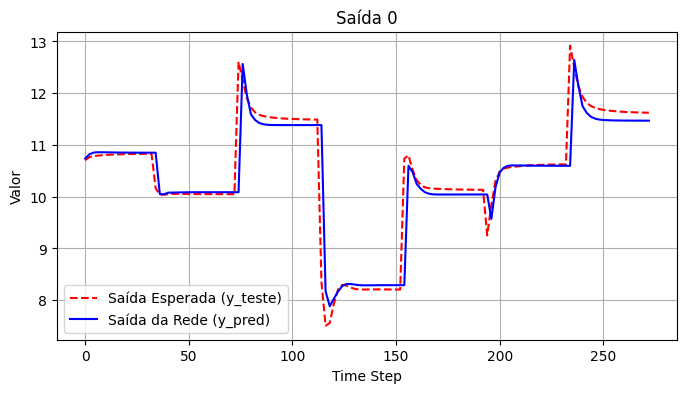

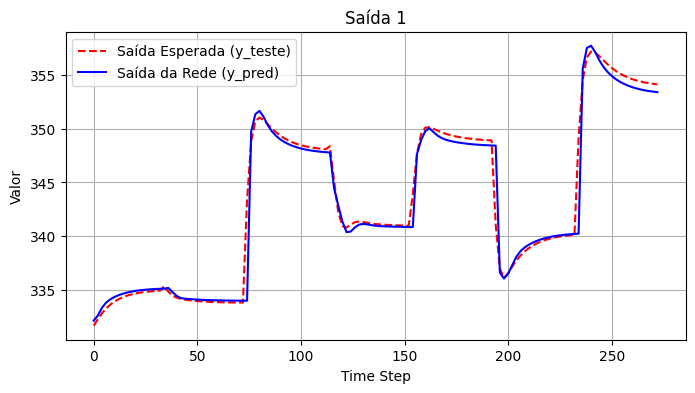

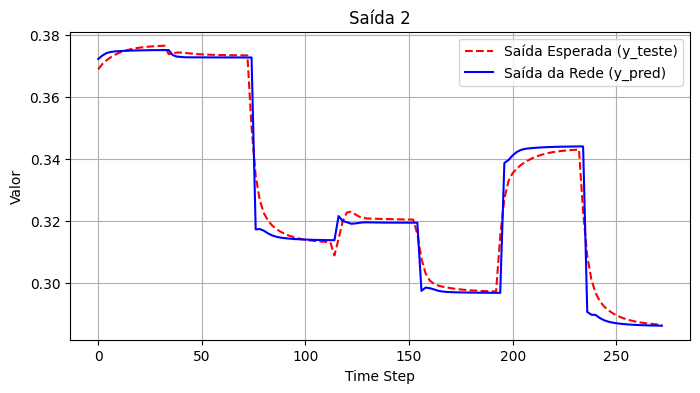

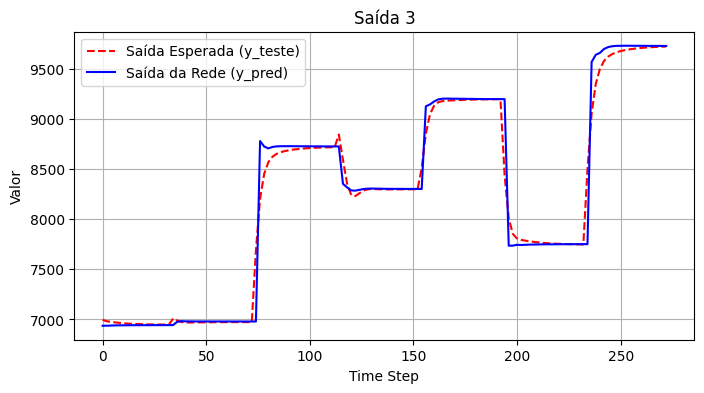

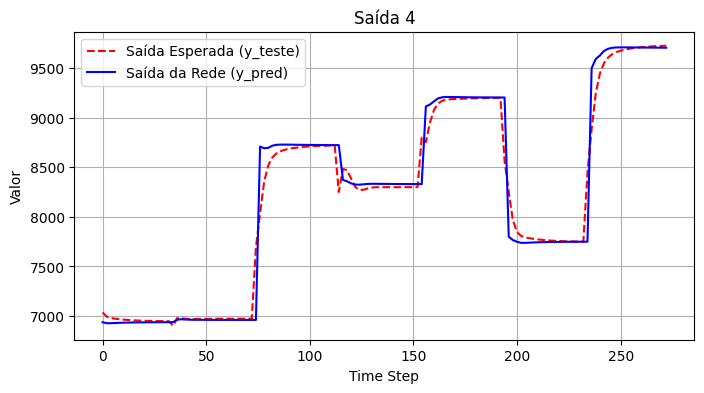

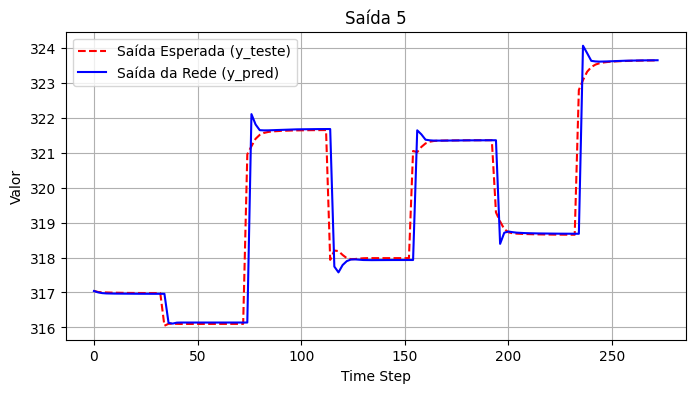

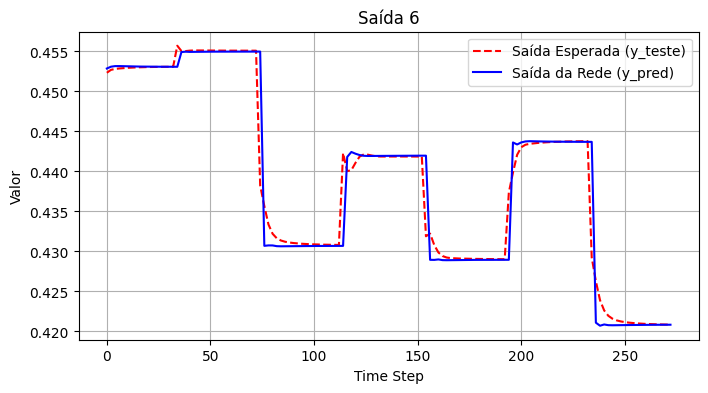

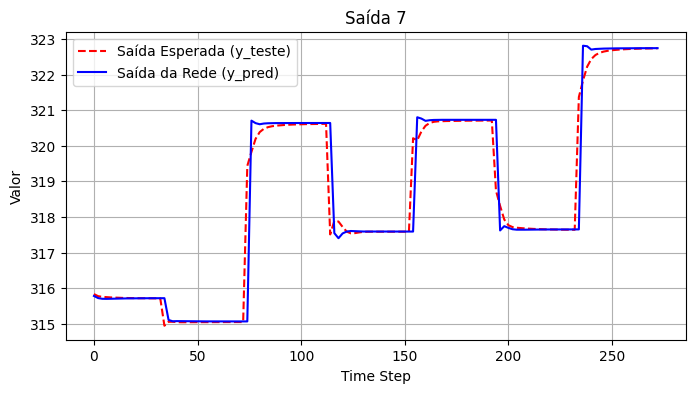

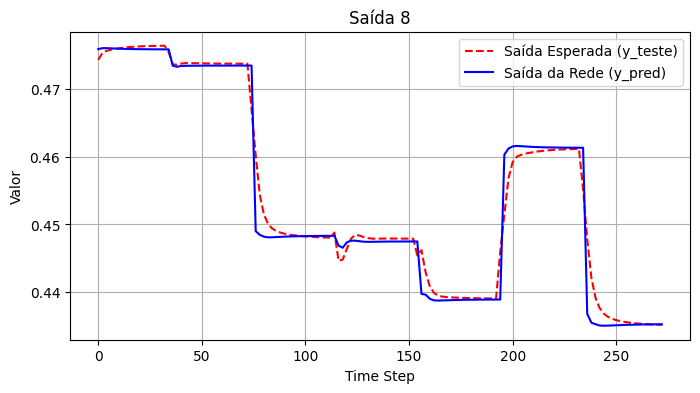

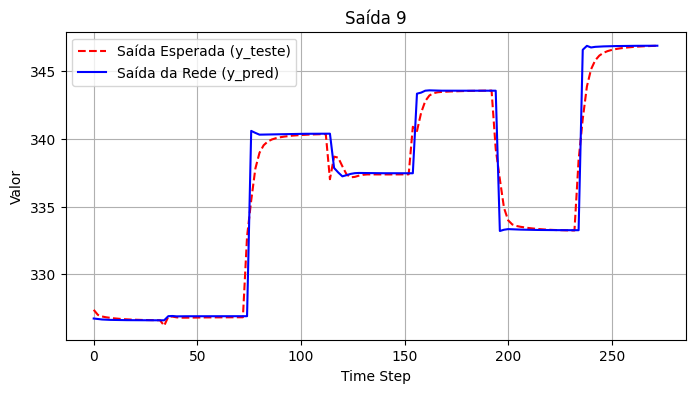

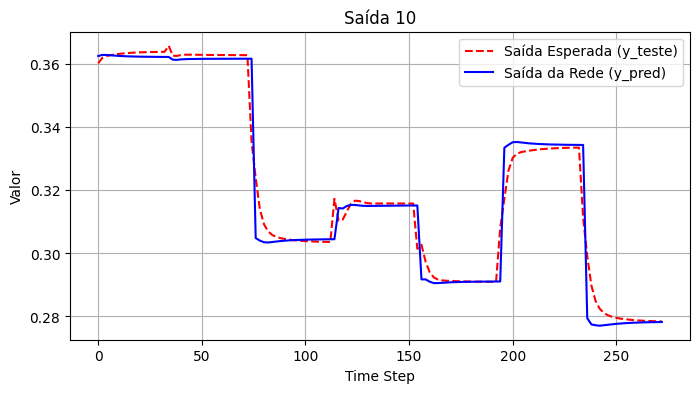

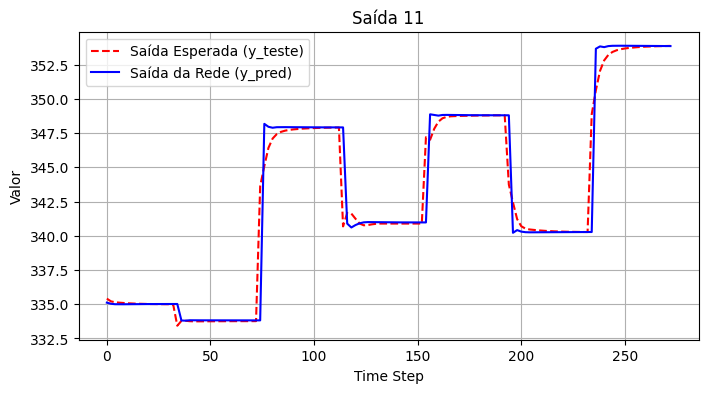

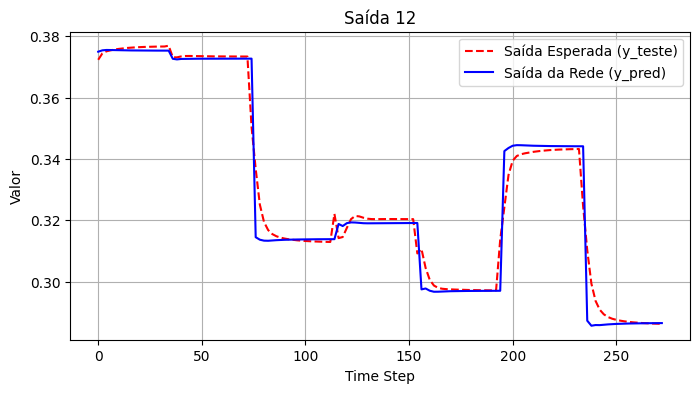

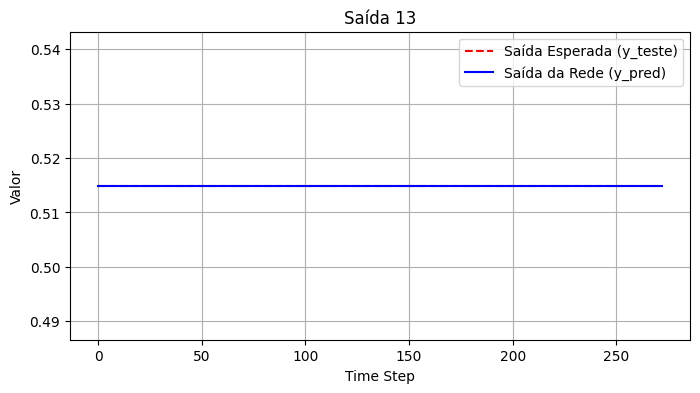

'[0, 1, 2, 3, 5, 7, 9, 11]'

In [17]:
import matplotlib.pyplot as plt

# Remover dimensões extras de y_pred e y_teste (se houver)
y_pred = y_pred.squeeze()
y_teste = y_teste.squeeze()

# Número de variáveis de saída
num_outputs = y_teste.shape[1]

# Ajustar o tamanho da lista time_steps para corresponder aos dados de teste
time_steps = time_steps[:y_teste.shape[0]]
 
# Criar os gráficos separadamente para cada saída
for i in range(num_outputs):
    plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
    plt.plot(time_steps, y_teste[:, i], label="Saída Esperada (y_teste)", color="red", linestyle="--")
    plt.plot(time_steps, y_pred[:, i], label="Saída da Rede (y_pred)", color="blue", linestyle="-")
    
    plt.xlabel("Time Step")
    plt.ylabel("Valor")
    plt.title(f"Saída {i}")  # Título do gráfico indicando o índice da saída
    plt.legend()
    plt.grid(True)
    
    plt.show()  # Mostrar o gráfico

"[0, 1, 2, 3, 5, 7, 9, 11]"